In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# The Portfolio Rebalancing Optimization using QAOA with soft constraints

In this notebook, we will apply the QAOA algorithm to solve the portfolio optimization problem using a soft constraint


$$
C_{RR}({\bf z}) = \sum_i (1-\lambda) r_i z_i - \lambda\sum_{ij} \sigma_{ij} z_i z_j
$$

$$
C_{TC}({\bf z}) = \sum_i T (1- \delta(z-y))
$$


The soft constraint that we impose will be given 

$$
H =C_{RR}({\bf z})+C_{TC}({\bf z})+A\left(D-\sum_i z_i \right)^2
$$

# Generate the inital ground state wave function of the reference Hamiltonian

[(0, 1), (2, 3), (4, 5), (6, 7)]

[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(4), cirq.LineQubit(5), cirq.LineQubit(6), cirq.LineQubit(7)]


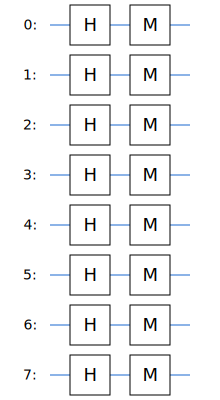

In [11]:
# Choose the number of portfolios to optimize
N = 4

# Define the transaction cost
T = sympy.symbols("T")
D = sympy.symbols("D")
A = sympy.symbols("A")

# Define our previous holdings
y = np.zeros(N)

# Define qubits on the grid.
qubits = [cirq.LineQubit(i) for i in range(2*N)]

# Define the indices that we will use
index_grid_pair = [(2*i,2*i+1) for i in range(0,N) ]

print(index_grid_pair)
print()

# Next we take these quibits which are in states |0> and apply a Hadamard gate to each one.
# this generates the eigenvectors of the reference Hamiltonian

print(qubits)

hadamard_operators = [cirq.H(qubits[i]) for i in range(len(qubits))]
measurements = cirq.Moment([cirq.measure(qubits[i],key=str(i)) for i in range(len(qubits))])


# Create the circuit from this 
circuit = cirq.Circuit((hadamard_operators,measurements))

#print(circuit)
SVGCircuit(circuit)


# Implementation of the mixing operator

We have generated the ground state wave function of the reference Hamiltonian. Now, we need to construc the Unitary operator $U({\beta})$ that represents the time evolution operator 

$$
\begin{align}
U({\bf \beta}) &= e^{-i\beta B}, \\
B &= \sum_{i} X_i.
\end{align}
$$

In the `cirq` api, this operator is implemented as 

$$
\text{cirq.rx} \equiv e^{-i X \beta / 2}.
$$



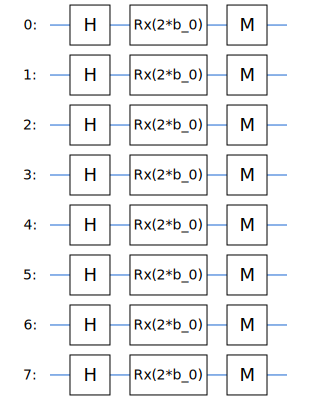

In [4]:
# Generate a list of symbolic arguments
beta_list = ["b_"+str(i) for i in range(1)]

# Convert them to symbolic numpy objects
betas = sympy.symbols(beta_list)


mixer_operators = [cirq.rx(2*betas[0]).on(qubits[i]) for i in range(len(qubits))]

# Create the circuit from this 
circuit = cirq.Circuit((hadamard_operators,mixer_operators,measurements))

#print(circuit)

SVGCircuit(circuit)

# Implementation of the exponential cost-function


For the portfolio optimization problem we have that the operator $Z_i$ is the difference between the Pauli-$z$ matrices
$$
\begin{align}
Z_i = \frac{1}{2}\left(z^{+}_{i}-z^{-}_{i} \right),
\end{align}
$$


where the $z^+_i$ and $z^-_i$ operate on the $i$-th qubit pair $|q_+,q_- \rangle$ and $q_{\pm}=\lbrace 0,1\rbrace$

$$
C_{RR}({\bf z}) = \sum_i (1-\lambda) r_i z_i - \lambda\sum_{ij} \sigma_{ij} z_i z_j
$$


$$
\begin{align}
e^{-i \gamma C_{RR}(z) } &=   \rm{Exp}\left(  i \gamma (1-\lambda) \sum_{k=1} \mu_k Z_k \right)  \rm{Exp}\left( - i \lambda \gamma  \sum_{ij} \sigma_{ij} Z_i Z_j \right) \\
&=   \prod_{k=1} \rm{Exp}\left( i \gamma (1-\lambda) \mu_k Z_k \right) \prod_{ij} \rm{Exp}\left( - i \lambda \gamma  \sigma_{ij} Z_i Z_j \right) \\
&=   \prod_{k=1} \rm{Exp}\left( i \gamma (1-\lambda) \frac{1}{2} \mu_k z^{+}_{k} \right)\left( i \gamma (1-\lambda) \frac{1}{2} \mu_k (-z^{-}_{k}) \right) \prod_{ij} \rm{Exp}\left( - i \lambda \frac{1}{4} \gamma  \sigma_{ij} \left(z^{+}_{i}z^{+}_{j}-z^{+}_{i}z^{-}_{j}-z^{-}_{i}z^{+}_{j}+z^{-}_{i}z^{-}_{j} \right) \right)
\end{align}
$$


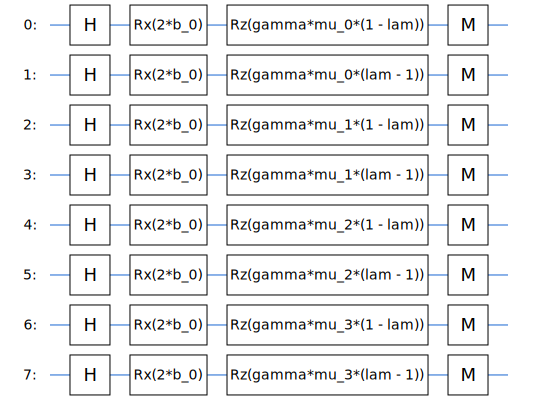

In [5]:
# Returns
mu = sympy.symbols(["mu_"+str(k) for k in range(N)])


# Convert them to symbolic numpy objects
lam,gamma = sympy.symbols("lam, gamma")

cost_returns_operators = [cirq.rz((-1)**int(i)*(1-lam)*gamma*mu[int(i/2)]).on(qubits[i]) for i in range(len(qubits))]

# Create the circuit from this 
circuit = cirq.Circuit((hadamard_operators,mixer_operators,cost_returns_operators,measurements))

#print(circuit)

SVGCircuit(circuit)

 ## Implementation of $e^{ i \gamma z_i z_j}$
 
This operator only contributes if $i \neq j$. If $i=j$ then the operator is simply an overall constant phase that can be ignored. First, we will implement $e^{ i \gamma \pi z_i z_j}$ by rescaling the $\gamma$ parameter. Furthermore, we note that an overall phase factor does not not change the final result when taking expectation values with wavefunctions, so we will remove an $e^{i\pi\gamma}$ phase from the implementation of this operator to simplify its decomposition.
 
 $$
 \begin{align}
  \text{Exp}\left(i \pi \gamma z_i z_j \right) &= 
 \begin{bmatrix}
   e^{\left(i \pi \gamma   \right)} & 0 & 0 & 0 \\
  0 & e^{-\left(i \pi \gamma   \right)} & 0 & 0 \\
  0 & 0 & e^{-\left(i \pi \gamma \right)} & 0 \\
  0 & 0 & 0 & e^{\left(i \pi \gamma  \right)}
  \end{bmatrix},\\
  &= 
 e^{i \pi \gamma}
 \begin{bmatrix}
   1 & 0 & 0 & 0 \\
  0 & e^{-2\left(i \pi \gamma   \right)} & 0 & 0 \\
  0 & 0 & e^{-2\left(i \pi \gamma \right)} & 0 \\
  0 & 0 & 0 &1
  \end{bmatrix},
 \end{align}
 $$
 
 Now, we note that in `cirq`, the above matrix is implemented as
 
 $$
 \text{cirq.ZZPowGate}(t) = 
   \begin{bmatrix}
   1 & 0 & 0 & 0 \\
  0 & e^{i\pi t} & 0 & 0 \\
  0 & 0 &  e^{i\pi t} & 0 \\
  0 & 0 & 0 &  1
  \end{bmatrix}.
 $$
 
 
 For the purposes of implementation also note that
 
 $$
 X_2  \equiv \left( I \otimes X \right)  = \begin{bmatrix}
  X & {\bf 0}\\
  {\bf 0} & X 
  \end{bmatrix}
   = \begin{bmatrix}
  0 & 1 & 0& 0\\
  1 & 0 & 0& 0\\
  0 & 0 & 0& 1\\
  0 & 0 & 1& 0\\
  \end{bmatrix},
 $$
 
  $$
 X_1  \equiv \left( X \otimes I \right)  = \begin{bmatrix}
  {\bf 0} & I\\
  I & {\bf 0} 
  \end{bmatrix}
   = \begin{bmatrix}
  0 & 0 & 1& 0\\
  0 & 0 & 0& 1\\
  1 & 0 & 0& 0\\
  0 & 1 & 0& 0\\
  \end{bmatrix},
 $$
 
   $$
 X_1  X_2 = X_2  X_1 = \begin{bmatrix}
  {\bf 0} & X\\
  X & {\bf 0} 
  \end{bmatrix}
   = \begin{bmatrix}
  0 & 0 & 0& 1\\
  0 & 0 & 1& 0\\
  0 & 1 & 0& 0\\
  1 & 0 & 0& 0\\
  \end{bmatrix}.
 $$

Finally, we arrive at the decomposition of our operator of interest in terms of gate operations
 
$$
\text{Exp}\left(i \pi \gamma z_i z_j \right) = e^{i\gamma \pi}\text{cirq.ZZPowGate}(-2\gamma)
$$
 

[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(4), cirq.LineQubit(5), cirq.LineQubit(6), cirq.LineQubit(7)]

++ Combinations
[(0, 2), (0, 4), (0, 6), (2, 0), (2, 4), (2, 6), (4, 0), (4, 2), (4, 6), (6, 0), (6, 2), (6, 4)]

-- Combinations
[(1, 3), (1, 5), (1, 7), (3, 1), (3, 5), (3, 7), (5, 1), (5, 3), (5, 7), (7, 1), (7, 3), (7, 5)]

+- Combinations
[(0, 1), (0, 3), (0, 5), (0, 7), (2, 1), (2, 3), (2, 5), (2, 7), (4, 1), (4, 3), (4, 5), (4, 7), (6, 1), (6, 3), (6, 5), (6, 7)]

-+ Combinations
[(1, 0), (1, 2), (1, 4), (1, 6), (3, 0), (3, 2), (3, 4), (3, 6), (5, 0), (5, 2), (5, 4), (5, 6), (7, 0), (7, 2), (7, 4), (7, 6)]

+- Combinations| Same portfolio
[(0, 1), (2, 3), (4, 5), (6, 7)]
\sigma_3_3

Example circut for application of Exp(zi zj) 



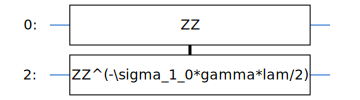

In [6]:
def exp_zz(gamma,qubit1,qubit2):
    """
    Exponentiates the Exp[]
    """
    
    #D1 = [ cirq.X.on(qubit2), cirq.CZPowGate(exponent= -2*gamma).on(qubit1,qubit2), cirq.X.on(qubit2)]
    #D2 = [ cirq.X.on(qubit1),cirq.X.on(qubit2), cirq.CZPowGate(exponent= -2*gamma).on(qubit1,qubit2),cirq.X.on(qubit1),cirq.X.on(qubit2)]
    
    #decomposition = D2.append(D1)
    
    return [cirq.ZZPowGate(exponent= -2*gamma).on(qubit1,qubit2)]



def remove_digonal_combinations(combination_list):
    """
    Simple utility function to remove the diagonal combinations from a list
    of possible connections
    """
    
    purged_list = []
    
    
    for i in range(len(index_grid_pp)):
        p1,p2 = combination_list[i]
    
        if(p1!=p2):
            purged_list.append((p1,p2))
    
    
    return purged_list

def map_combinations_to_portfolio_index(combination_list):
    
    
    portfolio_index= [ (int(combination_list[i][0]/2), int(combination_list[i][1]/2)) for i in range(len(combination_list))]
    
    return portfolio_index


# Covariance matrix
sigma = sympy.symbols([["\sigma_"+str(i)+"_"+str(j) for i in range(N)] for j in range(N)])

print(qubits)
print()
# Define the s^+ , s^- permutations that we will use for summations
index_grid_p = [2*i for i in range(0,N)]
index_grid_m = [2*i+1 for i in range(0,N)]
index_grid_pm = [(2*i,2*j+1) for i in range(0,N) for j in range(0,N) ]
index_grid_pm_ii = [(2*i,2*i+1) for i in range(0,N)]
index_grid_mp = [(2*i+1,2*j) for i in range(0,N) for j in range(0,N) ]
index_grid_pp = [(2*i,2*j) for i in range(0,N) for j in range(0,N)  ]
index_grid_mm = [(2*i+1,2*j+1) for i in range(0,N) for j in range(0,N) ]


index_grid_pp_offdiagonal  =  remove_digonal_combinations(index_grid_pp)
index_grid_mm_offdiagonal  =  remove_digonal_combinations(index_grid_mm)
index_grid_pm_offdiagonal  =  remove_digonal_combinations(index_grid_pm)
index_grid_mp_offdiagonal  =  remove_digonal_combinations(index_grid_mp)


index_grid_pp_portfolio = map_combinations_to_portfolio_index(index_grid_pp_offdiagonal)
index_grid_mm_portfolio = map_combinations_to_portfolio_index(index_grid_mm_offdiagonal)
index_grid_pm_portfolio = map_combinations_to_portfolio_index(index_grid_pm_offdiagonal)
index_grid_mp_portfolio = map_combinations_to_portfolio_index(index_grid_mp_offdiagonal)

print("++ Combinations")
print(index_grid_pp_offdiagonal)
print()
print("-- Combinations")
print(index_grid_mm_offdiagonal)
print()
print("+- Combinations")
print(index_grid_pm_offdiagonal)
print()
print("-+ Combinations")
print(index_grid_mp_offdiagonal)
print()
print("+- Combinations| Same portfolio")
print(index_grid_pm_ii)


k=15
print(sigma[int(index_grid_pp[k][0]/2)][int(index_grid_pp[k][1]/2)])

pp1,pp2 = index_grid_pp_offdiagonal[0]
pp1_portfolio, pp2_portfolio =index_grid_pp_portfolio[0]
circuit = cirq.Circuit(exp_zz(gamma*lam/4*sigma[pp1_portfolio][pp2_portfolio],qubit1=qubits[pp1],qubit2=qubits[pp2]))

print("")
print("Example circut for application of Exp(zi zj) \n")
#print(circuit)
SVGCircuit(circuit)
#print("")


# Implementation of of full volatility term


$$
\text{Exp}\left( \sum_{ij} \lambda \sigma_{ij}Z_i Z_j \right) = \text{Exp}\left( \sum_{ij} \frac{\lambda}{4}\sigma_{ij}\left(z^{+}_{i} z^{+}_{j}-z^{+}_{i} z^{-}_{j}-z^{-}_{i} z^{+}_{j}+z^{-}_{i} z^{-}_{j} \right) \right)
$$

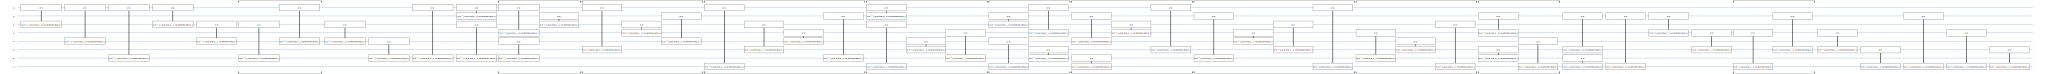

In [7]:
# Now let us build the entire circuit up to now

cost_volatility_operators_pp = []
cost_volatility_operators_mm = []
cost_volatility_operators_pm = []
cost_volatility_operators_mp = []

# Loop over all ++ combinations
for k in range(len(index_grid_pp_offdiagonal)):
    i_qubit,j_qubit = index_grid_pp_offdiagonal[k]
    i_portfolio, j_portfolio =index_grid_pp_portfolio[k]
    cost_volatility_operators_pp.append(exp_zz(gamma*lam/4*sigma[i_portfolio][j_portfolio],qubit1=qubits[i_qubit],qubit2=qubits[j_qubit]))

# Loop over all +- combinations
for k in range(len(index_grid_pm_offdiagonal)):
    i_qubit,j_qubit = index_grid_pm_offdiagonal[k]
    i_portfolio, j_portfolio =index_grid_pm_portfolio[k]
    cost_volatility_operators_pm.append(exp_zz((-1)*gamma*lam/4*sigma[i_portfolio][j_portfolio],qubit1=qubits[i_qubit],qubit2=qubits[j_qubit]))

    # Loop over all -+ combinations
for k in range(len(index_grid_mp_offdiagonal)):
    i_qubit,j_qubit = index_grid_mp_offdiagonal[k]
    i_portfolio, j_portfolio =index_grid_mp_portfolio[k]
    cost_volatility_operators_mp.append(exp_zz((-1)*gamma*lam/4*sigma[i_portfolio][j_portfolio],qubit1=qubits[i_qubit],qubit2=qubits[j_qubit]))

    # Loop over all -- combinations
for k in range(len(index_grid_mm_offdiagonal)):
    i_qubit,j_qubit = index_grid_mm_offdiagonal[k]
    i_portfolio, j_portfolio =index_grid_mm_portfolio[k]
    cost_volatility_operators_mm.append(exp_zz((-1)*gamma*lam/4*sigma[i_portfolio][j_portfolio],qubit1=qubits[i_qubit],qubit2=qubits[j_qubit]))


#cost_returns_operators = [cirq.rz((-1)**int(i)*(1-lam)*gamma*mu[int(i/2)]).on(qubits[i]) for i in range(len(qubits))]

# Create the circuit from this 
circuit = cirq.Circuit((cost_volatility_operators_pp,cost_volatility_operators_pm,cost_volatility_operators_mp,cost_volatility_operators_mm))
SVGCircuit(circuit)

# Implement the exponential operator of the transaction cost


$$
C_{TC}(z) = \frac{1}{4}T\left( 3+(1-y^2_i-y_i)z^{+}_{i}+(1-y^2_i+y_i)z^{-}_{i}+(2y^2_i-1)z^{+}_{i}z^{-}_{i} \right)
$$


$$
\text{Exp}\left( i\pi \gamma C_{TC}(z) \right) = \text{Exp}\left(  i\pi \gamma \frac{1}{4}T\left(1-y^2_i-y_i\right)z^{+}_{i}\right)\text{Exp}\left(  i\pi \gamma \frac{1}{4}T\left(1-y^2_i+y_i\right)z^{-}_{i} \right)\text{Exp}\left(  i\pi \gamma \frac{1}{4}T\left(2y^2_i-1\right)z^{+}_{i}z^{-}_{i} \right)
$$



[0, 2, 4, 6]


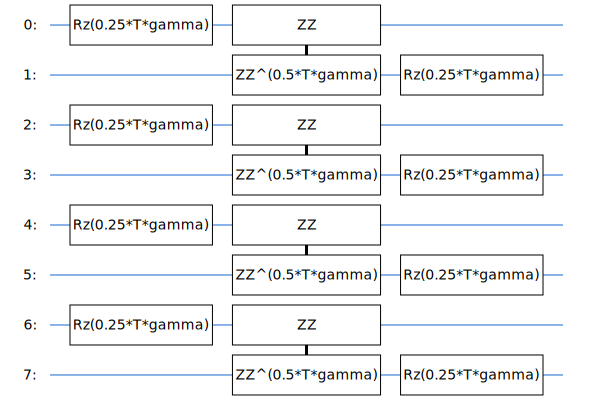

In [9]:
transaction_operators_p_i = []
transaction_operators_m_i = []
transaction_operators_pm_ii = []

print(index_grid_p)

for k in range(len(index_grid_p)):
    angle_i = (1/4)*T*(1-y[k]**2-y[k])*gamma
    i_qubit = index_grid_p[k]
    transaction_operators_p_i.append(cirq.rz(angle_i).on(qubits[i_qubit]) )
    
for k in range(len(index_grid_pm_ii)):
    angle_k = (1/4)*T*(2*y[k]**2-1)*gamma
    i_qubit, j_qubit = index_grid_pm_ii[k]
    i_portfolio, j_portfolio =index_grid_pm_ii[k]
    transaction_operators_pm_ii.append(exp_zz( angle_k,qubit1=qubits[i_qubit],qubit2=qubits[j_qubit]))

for k in range(len(index_grid_m)):
    angle_i = (1/4)*T*(1-y[k]**2+y[k])*gamma
    i_qubit = index_grid_m[k]
    transaction_operators_m_i.append(cirq.rz(angle_i).on(qubits[i_qubit]) )
    

circuit = cirq.Circuit((transaction_operators_p_i,transaction_operators_pm_ii,transaction_operators_m_i))
SVGCircuit(circuit)

# Now we implement the soft constraint Term


